In [287]:
import pandas as pd
import numpy as np
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import MinMaxScaler
from transformers import pipeline
from scipy.stats import mannwhitneyu
from scipy.stats import ttest_ind

In [ ]:
# Submissions
sub_pre_df = pd.read_csv("../../work/FCSS/LIWC-22 Results_anxiety_submission_pre_covid.csv")
sub_post_df =  pd.read_csv("../../work/FCSS/LIWC-22 Results_anxiety_submission_post_covid.csv")

# Comments
coms_pre_df = pd.read_csv("../../work/FCSS/LIWC-22 Results_anxiety_comments_pre_covid.csv")
coms_post_df =  pd.read_csv("../../work/FCSS/LIWC-22 Results_anxiety_comments_post_covid.csv")

# LIWC Reddit Baseline
baseline_df = pd.DataFrame(pd.read_excel("../../data/thomas_MH/LIWC/LIWC-22-Baseline-Reddit.xlsx"))
baseline_df

# Final Files

In [164]:
# Submissions
sub_pre_df = pd.read_csv("../../work/FCSS/submission_pre_covid_sentiment.csv")
sub_post_df =  pd.read_csv("../../work/FCSS/submission_post_covid_sentiment.csv")

# Comments
coms_pre_df = pd.read_csv("../../work/FCSS/comments_pre_covid_sentiment.csv")
coms_post_df =  pd.read_csv("../../work/FCSS/comments_post_covid_sentiment.csv")

# Check for NaN

In [165]:
print(sub_pre_df[['VADER_compound', 'Tone']].isnull().sum())
print(sub_post_df[['VADER_compound', 'Tone']].isnull().sum())

print(coms_pre_df[['VADER_compound', 'Tone']].isnull().sum())
print(coms_post_df[['VADER_compound', 'Tone']].isnull().sum())

VADER_compound       0
Tone              2550
dtype: int64
VADER_compound       0
Tone              1737
dtype: int64
VADER_compound        1
Tone              58050
dtype: int64
VADER_compound        1
Tone              63931
dtype: int64


In [166]:
# Drop rows with NaN in Tone and VADER_compound
sub_pre_df.dropna(subset=['Tone', 'VADER_compound'], inplace=True)
sub_post_df.dropna(subset=['Tone', 'VADER_compound'], inplace=True)
coms_pre_df.dropna(subset=['Tone', 'VADER_compound'], inplace=True)
coms_post_df.dropna(subset=['Tone', 'VADER_compound'], inplace=True)

In [149]:
# Fill NaN values in Tone with 50 (neutral)
sub_pre_df['Tone'].fillna(50, inplace=True)
sub_post_df['Tone'].fillna(50, inplace=True)
coms_pre_df['Tone'].fillna(50, inplace=True)
coms_post_df['Tone'].fillna(50, inplace=True)

# LIWC Sentiment (Tone)

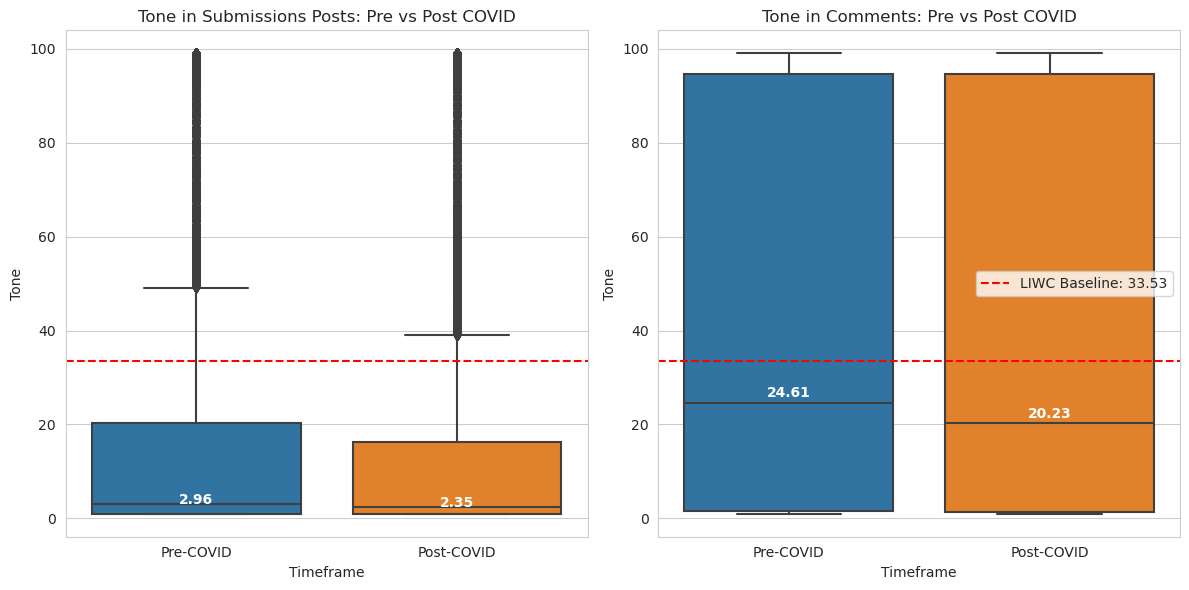

In [167]:
baseline_tone = baseline_df[baseline_df['LIWC-22-Stats'] == 'Tone']['Mean'].values[0]
sns.set_style("whitegrid")

# DF Pre and Post Covid for submissions and comments
sub_data = pd.DataFrame({
    'Tone': pd.concat([sub_pre_df['Tone'], sub_post_df['Tone']]),
    'Timeframe': ['Pre-COVID'] * len(sub_pre_df) + ['Post-COVID'] * len(sub_post_df)
})

coms_data = pd.DataFrame({
    'Tone': pd.concat([coms_pre_df['Tone'], coms_post_df['Tone']]),
    'Timeframe': ['Pre-COVID'] * len(coms_pre_df) + ['Post-COVID'] * len(coms_post_df)
})


plt.figure(figsize=(12, 6))

plt.subplot(1, 2, 1)
box_plot_sub = sns.boxplot(x='Timeframe', y='Tone', data=sub_data)
plt.axhline(y=baseline_tone, color='red', linestyle='--', label='LIWC Baseline: 33.53')  # Add red baseline line
plt.title('Tone in Submissions Posts: Pre vs Post COVID')

median_pre_sub = sub_pre_df['Tone'].median()
median_post_sub = sub_post_df['Tone'].median()

# calc vertical offset for annotation (for a better viz)
vertical_offset_sub = sub_pre_df['Tone'].median() * 0.05

# annotation of medians on the boxplot
box_plot_sub.text(0, median_pre_sub + vertical_offset_sub, 
                  f'{median_pre_sub:.2f}', 
                  horizontalalignment='center', size='medium', color='white', weight='semibold')
box_plot_sub.text(1, median_post_sub + vertical_offset_sub, 
                  f'{median_post_sub:.2f}', 
                  horizontalalignment='center', size='medium', color='white', weight='semibold')

# boxplot for comments tone (Pre vs Post)
plt.subplot(1, 2, 2)
box_plot_coms = sns.boxplot(x='Timeframe', y='Tone', data=coms_data)
# adds the red line based on the LIWC baseline
plt.axhline(y=baseline_tone, color='red', linestyle='--', label='LIWC Baseline: 33.53')
plt.title('Tone in Comments: Pre vs Post COVID')

median_pre_coms = coms_pre_df['Tone'].median()
median_post_coms = coms_post_df['Tone'].median()

# calc offset again
vertical_offset_coms = coms_pre_df['Tone'].median() * 0.05

# annotation of medians on the boxplot
box_plot_coms.text(0, median_pre_coms + vertical_offset_coms, 
                   f'{median_pre_coms:.2f}', 
                   horizontalalignment='center', size='medium', color='white', weight='semibold')
box_plot_coms.text(1, median_post_coms + vertical_offset_coms, 
                   f'{median_post_coms:.2f}', 
                   horizontalalignment='center', size='medium', color='white', weight='semibold')

plt.legend()
plt.tight_layout()
plt.savefig('../../work/FCSS/LIWC_sentiment_comparison_boxplot.png', format='png', dpi=300)
plt.show()

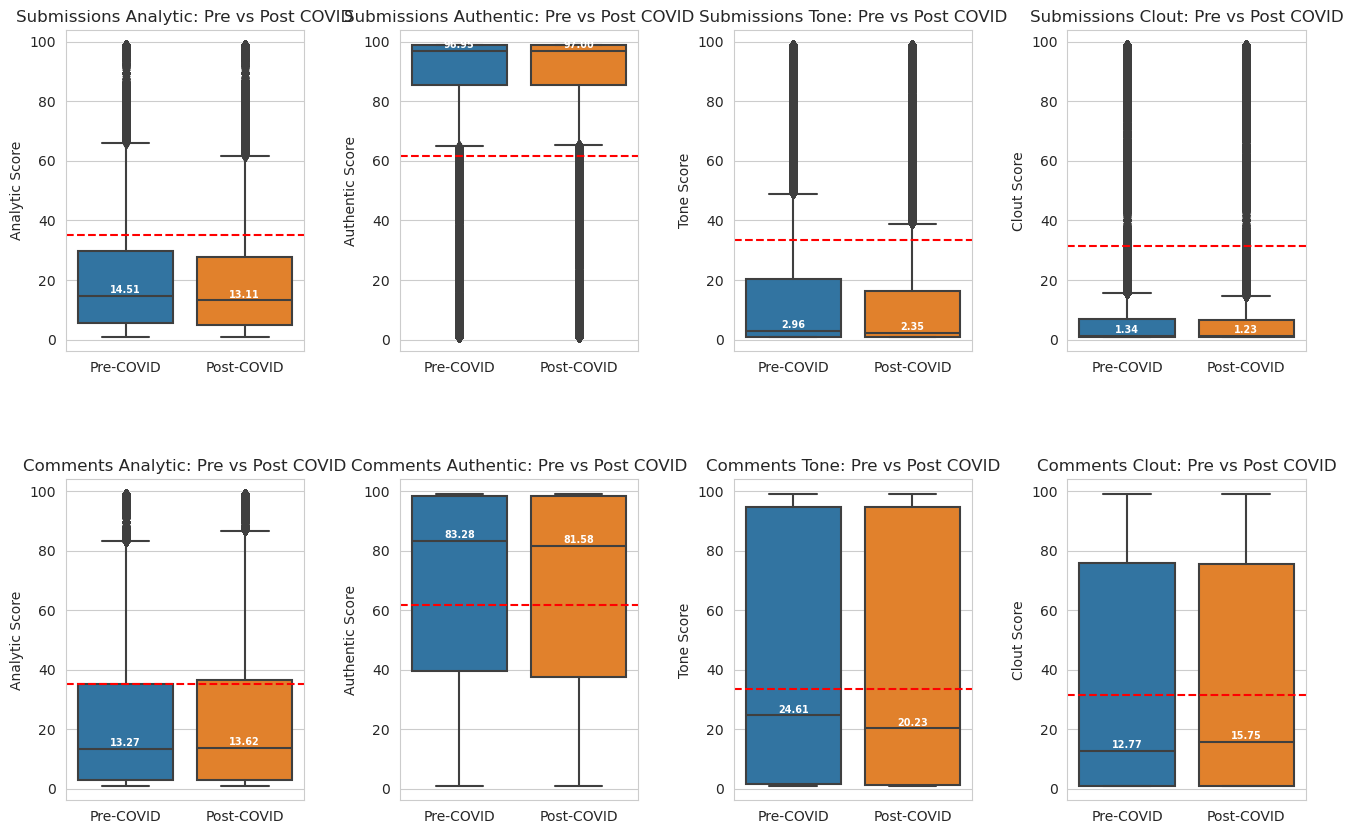

In [168]:
# List of LIWC dimensions to visualize
liwc_dimensions = ['Analytic', 'Authentic', 'Tone', 'Clout']

# Extract baseline values for these dimensions
baseline_values = baseline_df.set_index('LIWC-22-Stats').loc[liwc_dimensions, 'Mean'].to_dict()

fig, axes = plt.subplots(2, 4, figsize=(16, 10))
plt.subplots_adjust(hspace=0.4, wspace=0.4)

def plot_liwc_dimension(ax, pre_data, post_data, dimension, title_prefix):
    sns.boxplot(data=[pre_data[dimension], post_data[dimension]], ax=ax)
    ax.set_xticks([0, 1])
    ax.set_xticklabels(['Pre-COVID', 'Post-COVID'])
    ax.set_title(f'{title_prefix} {dimension}: Pre vs Post COVID')
    ax.set_ylabel(f'{dimension} Score')
    ax.axhline(y=baseline_values[dimension], color='red', linestyle='--', label=f'Baseline: {baseline_values[dimension]:.2f}')

    # calc and annotate medians
    medians = [pre_data[dimension].median(), post_data[dimension].median()]
    for xtick, median in enumerate(medians):
        ax.text(xtick, median + 1, f'{median:.2f}', 
                horizontalalignment='center', size='x-small', color='white', weight='semibold')

# submissions
for i, dimension in enumerate(liwc_dimensions):
    plot_liwc_dimension(axes[0, i], sub_pre_df, sub_post_df, dimension, 'Submissions')

# comments
for i, dimension in enumerate(liwc_dimensions):
    plot_liwc_dimension(axes[1, i], coms_pre_df, coms_post_df, dimension, 'Comments')

plt.savefig('../../work/FCSS/LIWC_summary_measures_comparison_boxplot.png', format='png', dpi=300)
    
# Show plot
plt.show()


# Categorize LIWC Sentiment (TONE)

In [169]:
liwc_bins = [0, 40, 60, 100]  # Neutral is between 45 and 55
liwc_labels = ['Negative', 'Neutral', 'Positive']

# Submissions
sub_pre_df['LIWC_Sentiment'] = pd.cut(sub_pre_df['Tone'], bins=liwc_bins, labels=liwc_labels)
sub_post_df['LIWC_Sentiment'] = pd.cut(sub_post_df['Tone'], bins=liwc_bins, labels=liwc_labels)

# Comments
coms_pre_df['LIWC_Sentiment'] = pd.cut(coms_pre_df['Tone'], bins=liwc_bins, labels=liwc_labels)
coms_post_df['LIWC_Sentiment'] = pd.cut(coms_post_df['Tone'], bins=liwc_bins, labels=liwc_labels)

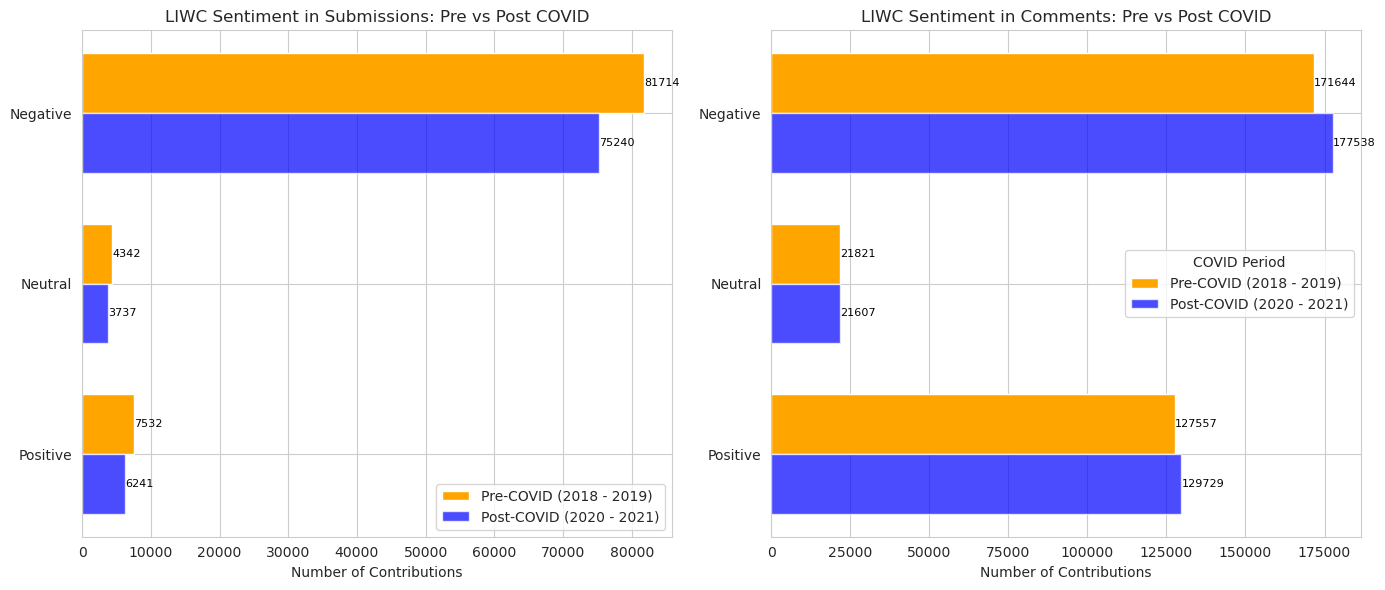

In [170]:
pre_covid_color = 'orange'
post_covid_color = 'blue'

sns.set_style("whitegrid")

index = np.arange(3)
bar_width = 0.35

# Plot for Submissions and Comments
plt.figure(figsize=(14, 6))

# Submissions
plt.subplot(1, 2, 1)
pre_liwc_counts = sub_pre_df['LIWC_Sentiment'].value_counts().reindex(['Positive', 'Neutral', 'Negative'], fill_value=0)
post_liwc_counts = sub_post_df['LIWC_Sentiment'].value_counts().reindex(['Positive', 'Neutral', 'Negative'], fill_value=0)

# Plot bars with correct positioning: Pre-COVID above, Post-COVID below
plt.barh(index + bar_width / 2, pre_liwc_counts.values, bar_width, color=pre_covid_color, label='Pre-COVID (2018 - 2019)')
# plt.barh(index - bar_width / 2, post_liwc_counts.values, bar_width, edgecolor='black', linewidth=1.5, color=post_covid_color, alpha=0.7, label='Post-COVID (2020 - 2021)')
plt.barh(index - bar_width / 2, post_liwc_counts.values, bar_width, color=post_covid_color, alpha=0.7, label='Post-COVID (2020 - 2021)')

# adding values on bars
for i, value in enumerate(pre_liwc_counts.values):
    plt.text(value + 50, index[i] + bar_width / 2, str(value), va='center', ha='left', fontsize=8, color='black')
for i, value in enumerate(post_liwc_counts.values):
    plt.text(value + 50, index[i] - bar_width / 2, str(value), va='center', ha='left', fontsize=8, color='black')

plt.yticks(index, pre_liwc_counts.index)
plt.title('LIWC Sentiment in Submissions: Pre vs Post COVID')
plt.xlabel('Number of Contributions')
plt.legend()

# Comments
plt.subplot(1, 2, 2)
pre_liwc_counts_com = coms_pre_df['LIWC_Sentiment'].value_counts().reindex(['Positive', 'Neutral', 'Negative'], fill_value=0)
post_liwc_counts_com = coms_post_df['LIWC_Sentiment'].value_counts().reindex(['Positive', 'Neutral', 'Negative'], fill_value=0)

# Plot bars with correct positioning: Pre-COVID above, Post-COVID below
plt.barh(index + bar_width / 2, pre_liwc_counts_com.values, bar_width, color=pre_covid_color, label='Pre-COVID (2018 - 2019)')
# plt.barh(index - bar_width / 2, post_liwc_counts_com.values, bar_width, edgecolor='black', linewidth=1.5, color=post_covid_color, alpha=0.7, label='Post-COVID (2020 - 2021)')
plt.barh(index - bar_width / 2, post_liwc_counts_com.values, bar_width, color=post_covid_color, alpha=0.7, label='Post-COVID (2020 - 2021)')

# Add values on bars
for i, value in enumerate(pre_liwc_counts_com.values):
    plt.text(value + 50, index[i] + bar_width / 2, str(value), va='center', ha='left', fontsize=8, color='black')
for i, value in enumerate(post_liwc_counts_com.values):
    plt.text(value + 50, index[i] - bar_width / 2, str(value), va='center', ha='left', fontsize=8, color='black')

plt.yticks(index, pre_liwc_counts_com.index)
plt.title('LIWC Sentiment in Comments: Pre vs Post COVID')
plt.xlabel('Number of Contributions')
plt.legend(title="COVID Period")

# Adjust layout and show plot
plt.tight_layout()

plt.savefig('../../work/FCSS/LIWC_sentiment_comparison.png', format='png', dpi=300)

plt.show()


# Vader Sentiment - MinMax Scaled to fit LIWC Tone

In [163]:
analyzer = SentimentIntensityAnalyzer()
scaler = MinMaxScaler(feature_range=(0, 1))

def get_vader_compound_score(text):
    return float(analyzer.polarity_scores(text)['compound'])

# Just to be safe
sub_pre_df['Text'] = sub_pre_df['Text'].astype(str)
sub_post_df['Text'] = sub_post_df['Text'].astype(str)
coms_pre_df['Text'] = coms_pre_df['Text'].astype(str)
coms_post_df['Text'] = coms_post_df['Text'].astype(str)


# Submissions
sub_pre_df['VADER_compound'] = sub_pre_df['Text'].apply(get_vader_compound_score)
sub_post_df['VADER_compound'] = sub_post_df['Text'].apply(get_vader_compound_score)

# Comments
coms_pre_df['VADER_compound'] = coms_pre_df['Text'].apply(get_vader_compound_score)
coms_post_df['VADER_compound'] = coms_post_df['Text'].apply(get_vader_compound_score)

# concat all dataframes for scaling (Submissions + Comments)
combined_df = pd.concat([sub_pre_df[['VADER_compound']], sub_post_df[['VADER_compound']], coms_pre_df[['VADER_compound']], coms_post_df[['VADER_compound']]])

# Fit the scaler on the combined data so that the minmax scaling is correct based on the WHOLE vader_compound data.
scaler.fit(combined_df[['VADER_compound']])

# Min Max Scaling to fit LIWC Dimensions 0-100 insead of -1 to 1
sub_pre_df['VADER_scaled'] = scaler.fit_transform(sub_pre_df[['VADER_compound']]) * 100
print('Submissions Pre-Covid DONE')
sub_post_df['VADER_scaled'] = scaler.fit_transform(sub_post_df[['VADER_compound']]) * 100
print('Submissions Post-Covid DONE')
coms_pre_df['VADER_scaled'] = scaler.fit_transform(coms_pre_df[['VADER_compound']]) * 100
print('Comments Pre-Covid DONE')
coms_post_df['VADER_scaled'] = scaler.fit_transform(coms_post_df[['VADER_compound']]) * 100
print('Comments Post-Covid DONE')


KeyboardInterrupt: 

In [171]:
sub_pre_df[['subreddit', 'Text', 'Tone', 'VADER_scaled', 'VADER_compound']]

,subreddit,Text,Tone,VADER_scaled,VADER_compound
0,Anxiety,My Mom is crying because i refused to call to ...,1.96,2.595260,-0.9480
1,Anxiety,How to deal with 'heart attacks' every night?\...,1.00,48.709871,-0.0258
2,Anxiety,How does it feel to not have anxiety?\n I've h...,1.00,1.760176,-0.9647
3,Anxiety,I could do with some advice. Im really struggl...,2.26,0.880088,-0.9823
4,Anxiety,Stuck at a party\nI’m at a completely fine NYE...,50.81,96.294629,0.9258
...,...,...,...,...,...
96133,Anxiety,"Does anyone else have chest pain, not just dur...",1.00,5.115512,-0.8976
96134,Anxiety,Anyone else feel depressed and anxious every n...,3.38,14.251425,-0.7149
96135,Anxiety,I am not ready for the new year\nIt just came ...,70.15,22.472247,-0.5505
96136,Anxiety,Is this technically Anxiety?\nI've had issues ...,16.08,85.223522,0.7044


# Visualize VADER Sentiment (MIN MAX SCALED)

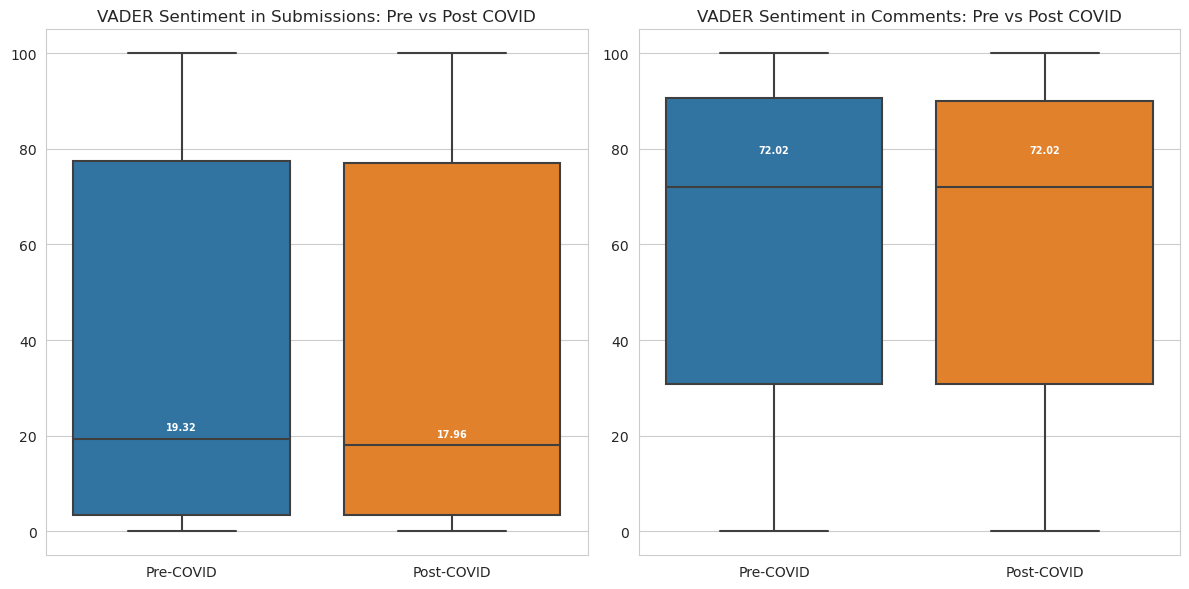

In [175]:
sns.set_style("whitegrid")
plt.figure(figsize=(12, 6))

# Submissions
plt.subplot(1, 2, 1)
box_plot_sub = sns.boxplot(data=[sub_pre_df['VADER_scaled'], sub_post_df['VADER_scaled']])
plt.xticks([0, 1], ['Pre-COVID', 'Post-COVID'])
plt.title('VADER Sentiment in Submissions: Pre vs Post COVID')

# calc medians for annotation
medians_sub = [sub_pre_df['VADER_scaled'].median(), sub_post_df['VADER_scaled'].median()]
vertical_offset_sub = (sub_pre_df['VADER_scaled'].median() + sub_post_df['VADER_scaled'].median()) * 0.05

# annotation median values
for xtick in [0, 1]:
    plt.text(xtick, medians_sub[xtick] + vertical_offset_sub, f'{medians_sub[xtick]:.2f}', 
             horizontalalignment='center', size='x-small', color='white', weight='semibold')

# Comments
plt.subplot(1, 2, 2)
box_plot_coms = sns.boxplot(data=[coms_pre_df['VADER_scaled'], coms_post_df['VADER_scaled']])
plt.xticks([0, 1], ['Pre-COVID', 'Post-COVID'])
plt.title('VADER Sentiment in Comments: Pre vs Post COVID')

# calc medians for annotation
medians_coms = [coms_pre_df['VADER_scaled'].median(), coms_post_df['VADER_scaled'].median()]
vertical_offset_coms = (coms_pre_df['VADER_scaled'].median() + coms_post_df['VADER_scaled'].median()) * 0.05

# annotation median values
for xtick in [0, 1]:
    plt.text(xtick, medians_coms[xtick] + vertical_offset_coms, f'{medians_coms[xtick]:.2f}', 
             horizontalalignment='center', size='x-small', color='white', weight='semibold')

plt.tight_layout()
plt.savefig('../../work/FCSS/VADER_sentiment_comparison_boxplot.png', format='png', dpi=300)
plt.show()

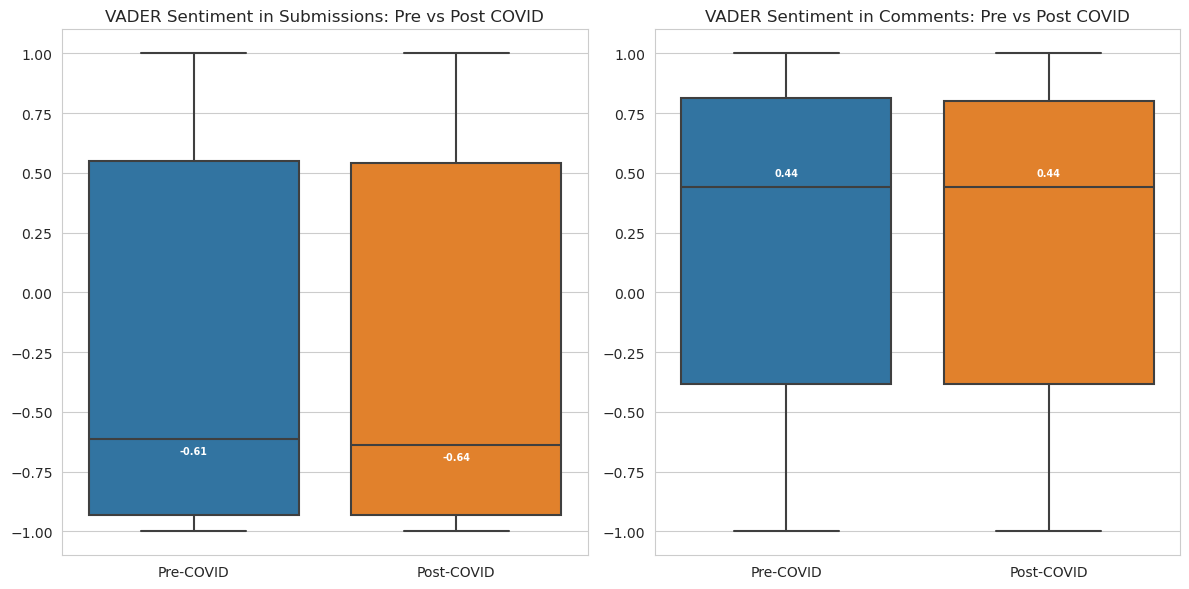

In [174]:
sns.set_style("whitegrid")
plt.figure(figsize=(12, 6))

# Submissions
plt.subplot(1, 2, 1)
box_plot_sub = sns.boxplot(data=[sub_pre_df['VADER_compound'], sub_post_df['VADER_compound']])
plt.xticks([0, 1], ['Pre-COVID', 'Post-COVID'])
plt.title('VADER Sentiment in Submissions: Pre vs Post COVID')

# clac medians for annotation
medians_sub = [sub_pre_df['VADER_compound'].median(), sub_post_df['VADER_compound'].median()]
vertical_offset_sub = (sub_pre_df['VADER_compound'].median() + sub_post_df['VADER_compound'].median()) * 0.05

# annotation median values
for xtick in [0, 1]:
    plt.text(xtick, medians_sub[xtick] + vertical_offset_sub, f'{medians_sub[xtick]:.2f}', 
             horizontalalignment='center', size='x-small', color='white', weight='semibold')

# Comments
plt.subplot(1, 2, 2)
box_plot_coms = sns.boxplot(data=[coms_pre_df['VADER_compound'], coms_post_df['VADER_compound']])
plt.xticks([0, 1], ['Pre-COVID', 'Post-COVID'])
plt.title('VADER Sentiment in Comments: Pre vs Post COVID')

# calc medians for annotation
medians_coms = [coms_pre_df['VADER_compound'].median(), coms_post_df['VADER_compound'].median()]
vertical_offset_coms = (coms_pre_df['VADER_compound'].median() + coms_post_df['VADER_compound'].median()) * 0.05

# annotation median values
for xtick in [0, 1]:
    plt.text(xtick, medians_coms[xtick] + vertical_offset_coms, f'{medians_coms[xtick]:.2f}', 
             horizontalalignment='center', size='x-small', color='white', weight='semibold')

plt.tight_layout()
plt.show()

# Check Vader Similarity in Comments

In [176]:
print("Pre-COVID Comments VADER Compound Summary:")
print(coms_pre_df['VADER_compound'].describe())
print("\nPost-COVID Comments VADER Compound Summary:")
print(coms_post_df['VADER_compound'].describe())

print("Unique values in Pre-COVID comments:")
print(coms_pre_df['VADER_compound'].unique())
print("\nUnique values in Post-COVID comments:")
print(coms_post_df['VADER_compound'].unique())

print(f"Number of rows in Pre-COVID comments: {len(coms_pre_df)}")
print(f"Number of rows in Post-COVID comments: {len(coms_post_df)}")

Pre-COVID Comments VADER Compound Summary:
count    321022.000000
mean          0.227205
std           0.649452
min          -0.999900
25%          -0.381800
50%           0.440400
75%           0.811900
max           0.999900
Name: VADER_compound, dtype: float64

Post-COVID Comments VADER Compound Summary:
count    328874.000000
mean          0.225839
std           0.645772
min          -0.999900
25%          -0.381800
50%           0.440400
75%           0.802000
max           1.000000
Name: VADER_compound, dtype: float64
Unique values in Pre-COVID comments:
[ 0.9081 -0.2815  0.     ...  0.535   0.1482  0.0858]

Unique values in Post-COVID comments:
[-0.1615 -0.7251  0.7906 ...  0.2877  0.3932 -0.4346]
Number of rows in Pre-COVID comments: 321022
Number of rows in Post-COVID comments: 328874


In [178]:
coms_pre_df['VADER_Sentiment'] = pd.cut(coms_pre_df['VADER_compound'], bins=[-1, -0.5, 0.5, 1], labels=['Negative', 'Neutral', 'Positive'])
coms_post_df['VADER_Sentiment'] = pd.cut(coms_post_df['VADER_compound'], bins=[-1, -0.5, 0.5, 1], labels=['Negative', 'Neutral', 'Positive'])

print("Pre-COVID Sentiment Distribution:")
print(coms_pre_df['VADER_Sentiment'].value_counts(normalize=True))
print("\nPost-COVID Sentiment Distribution:")
print(coms_post_df['VADER_Sentiment'].value_counts(normalize=True))

Pre-COVID Sentiment Distribution:
VADER_Sentiment
Positive    0.466195
Neutral     0.320395
Negative    0.213409
Name: proportion, dtype: float64

Post-COVID Sentiment Distribution:
VADER_Sentiment
Positive    0.46388
Neutral     0.32472
Negative    0.21140
Name: proportion, dtype: float64


In [179]:

stat, p = mannwhitneyu(coms_pre_df['VADER_compound'], coms_post_df['VADER_compound'])
print(f'Mann-Whitney U Test: Statistic={stat}, p-value={p}')
if p < 0.05:
    print("The sentiment distributions are significantly different.")
else:
    print("No significant difference in sentiment distributions.")

Mann-Whitney U Test: Statistic=53007685281.5, p-value=0.0036528930713773736
The sentiment distributions are significantly different.


# Categorize VADER Sentiment

In [180]:
# Updated vader_bins matching VADER documentation thresholds
# Negative <= -0.5, -0.5 < Neutral < 0.5, Positive >= 0.5
vader_bins = [-1, -0.5, 0.5, 1]  
vader_labels = ['Negative', 'Neutral', 'Positive']

# Ensure binning includes right-side boundaries
sub_pre_df['VADER_Sentiment'] = pd.cut(sub_pre_df['VADER_compound'], bins=vader_bins, labels=vader_labels, right=True, include_lowest=True)
sub_post_df['VADER_Sentiment'] = pd.cut(sub_post_df['VADER_compound'], bins=vader_bins, labels=vader_labels, right=True, include_lowest=True)

coms_pre_df['VADER_Sentiment'] = pd.cut(coms_pre_df['VADER_compound'], bins=vader_bins, labels=vader_labels, right=True, include_lowest=True)
coms_post_df['VADER_Sentiment'] = pd.cut(coms_post_df['VADER_compound'], bins=vader_bins, labels=vader_labels, right=True, include_lowest=True)

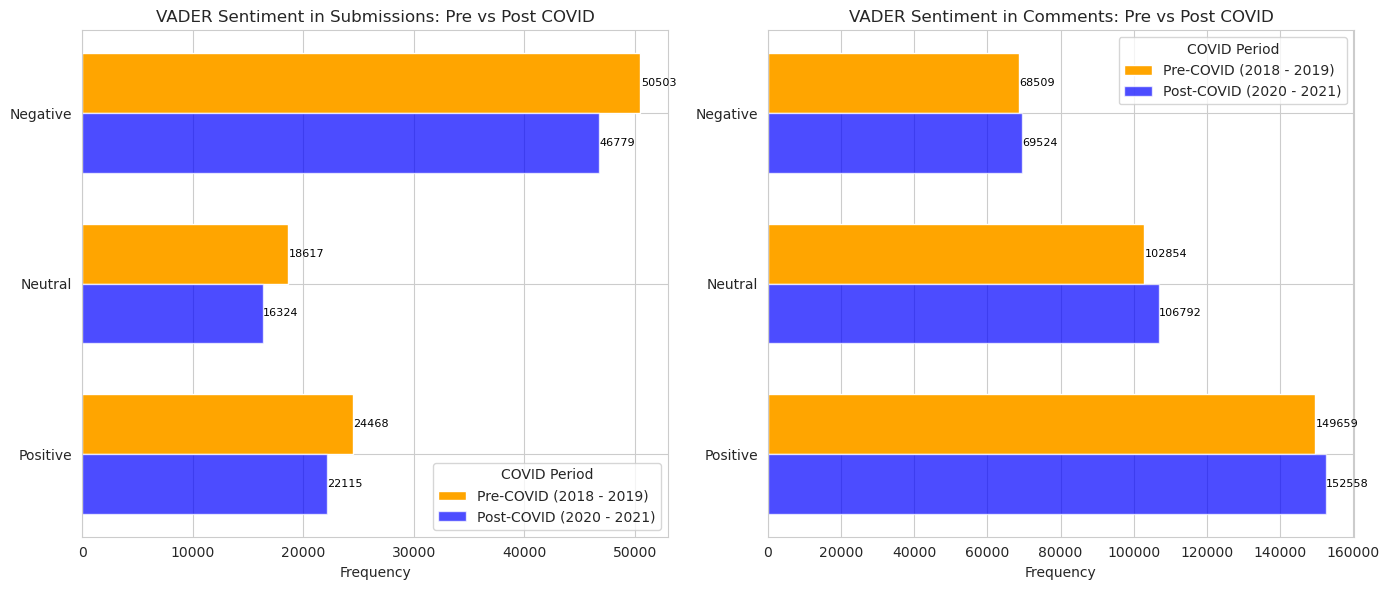

In [281]:
pre_covid_color = 'orange'
post_covid_color = 'blue'

sns.set_style("whitegrid")

index = np.arange(3)
bar_width = 0.35

# Plot for Submissions and Comments
plt.figure(figsize=(14, 6))

# Submissions
plt.subplot(1, 2, 1)
pre_vader_counts = sub_pre_df['VADER_Sentiment'].value_counts().reindex(['Positive', 'Neutral', 'Negative'], fill_value=0)
post_vader_counts = sub_post_df['VADER_Sentiment'].value_counts().reindex(['Positive', 'Neutral', 'Negative'], fill_value=0)

# Plot bars with correct positioning: Pre-COVID above, Post-COVID below
plt.barh(index + bar_width / 2, pre_vader_counts.values, bar_width, color=pre_covid_color, label='Pre-COVID (2018 - 2019)')
plt.barh(index - bar_width / 2, post_vader_counts.values, bar_width, color=post_covid_color, alpha=0.7, label='Post-COVID (2020 - 2021)')

# Add values on bars
for i, value in enumerate(pre_vader_counts.values):
    plt.text(value + 50, index[i] + bar_width / 2, str(value), va='center', ha='left', fontsize=8, color='black')
for i, value in enumerate(post_vader_counts.values):
    plt.text(value + 50, index[i] - bar_width / 2, str(value), va='center', ha='left', fontsize=8, color='black')

plt.yticks(index, pre_vader_counts.index)
plt.title('VADER Sentiment in Submissions: Pre vs Post COVID')
plt.xlabel('Frequency')
plt.legend(title="COVID Period")

# Comments
plt.subplot(1, 2, 2)
pre_vader_counts_com = coms_pre_df['VADER_Sentiment'].value_counts().reindex(['Positive', 'Neutral', 'Negative'], fill_value=0)
post_vader_counts_com = coms_post_df['VADER_Sentiment'].value_counts().reindex(['Positive', 'Neutral', 'Negative'], fill_value=0)

# Plot bars with correct positioning: Pre-COVID above, Post-COVID below
plt.barh(index + bar_width / 2, pre_vader_counts_com.values, bar_width, color=pre_covid_color, label='Pre-COVID (2018 - 2019)')
plt.barh(index - bar_width / 2, post_vader_counts_com.values, bar_width, color=post_covid_color, alpha=0.7, label='Post-COVID (2020 - 2021)')

# Add values on bars
for i, value in enumerate(pre_vader_counts_com.values):
    plt.text(value + 50, index[i] + bar_width / 2, str(value), va='center', ha='left', fontsize=8, color='black')
for i, value in enumerate(post_vader_counts_com.values):
    plt.text(value + 50, index[i] - bar_width / 2, str(value), va='center', ha='left', fontsize=8, color='black')

plt.yticks(index, pre_vader_counts_com.index)
plt.title('VADER Sentiment in Comments: Pre vs Post COVID')
plt.xlabel('Frequency')
plt.legend(title="COVID Period")

# Adjust layout and show plot
plt.tight_layout()
plt.savefig('../../work/FCSS/VADER_sentiment_comparison.png', format='png', dpi=300)
plt.show()

# BERT Sentiment Analysis

In [ ]:
%%time
from transformers import pipeline

# Load a pre-trained sentiment-analysis pipeline just like in the Lecture Exercise 3
sentiment_analyzer = pipeline("sentiment-analysis", model="distilbert-base-uncased-finetuned-sst-2-english", truncation=True)

def analyze_sentiment(text):
    # Truncate text to fit within model limits (512 tokens)
    result = sentiment_analyzer(text[:512])[0]
    # Extract 'POSITIVE' or 'NEGATIVE'
    label = result['label']
    # Confidence score
    score = result['score']
    return label, score

# pd.apply sentiment analysis safely on Text columns
sub_pre_df['BERT_sentiment'] = sub_pre_df['Text'].apply(lambda x: analyze_sentiment(str(x)))
print('Submissions Pre-Covid DONE')
sub_post_df['BERT_sentiment'] = sub_post_df['Text'].apply(lambda x: analyze_sentiment(str(x)))
print('Submissions Post-Covid DONE')
coms_pre_df['BERT_sentiment'] = coms_pre_df['Text'].apply(lambda x: analyze_sentiment(str(x)))
print('Comments Pre-Covid DONE')
coms_post_df['BERT_sentiment'] = coms_post_df['Text'].apply(lambda x: analyze_sentiment(str(x)))
print('Comments Post-Covid DONE')

# splitting BERT_sentiment tuples into separate columns
sub_pre_df[['BERT_label', 'BERT_score']] = pd.DataFrame(sub_pre_df['BERT_sentiment'].tolist(), index=sub_pre_df.index)
sub_post_df[['BERT_label', 'BERT_score']] = pd.DataFrame(sub_post_df['BERT_sentiment'].tolist(), index=sub_post_df.index)
coms_pre_df[['BERT_label', 'BERT_score']] = pd.DataFrame(coms_pre_df['BERT_sentiment'].tolist(), index=coms_pre_df.index)
coms_post_df[['BERT_label', 'BERT_score']] = pd.DataFrame(coms_post_df['BERT_sentiment'].tolist(), index=coms_post_df.index)

# Optionally drop the combined sentiment column
# sub_pre_df.drop(columns=['BERT_sentiment'], inplace=True)
# sub_post_df.drop(columns=['BERT_sentiment'], inplace=True)
# coms_pre_df.drop(columns=['BERT_sentiment'], inplace=True)
# coms_post_df.drop(columns=['BERT_sentiment'], inplace=True)

In [121]:
sub_pre_df[['subreddit', 'Text', 'Tone', 'VADER_scaled', 'BERT_label', 'BERT_score', 'BERT_sentiment']]

,subreddit,Text,Tone,VADER_scaled,BERT_label,BERT_score,BERT_sentiment
0,Anxiety,My Mom is crying because i refused to call to ...,1.96,2.595260,NEGATIVE,0.997812,"(NEGATIVE, 0.9978119134902954)"
1,Anxiety,How to deal with 'heart attacks' every night?\...,1.00,48.709871,NEGATIVE,0.998480,"(NEGATIVE, 0.9984802603721619)"
2,Anxiety,How does it feel to not have anxiety?\n I've h...,1.00,1.760176,POSITIVE,0.980821,"(POSITIVE, 0.9808213710784912)"
3,Anxiety,I could do with some advice. Im really struggl...,2.26,0.880088,NEGATIVE,0.989049,"(NEGATIVE, 0.9890487194061279)"
4,Anxiety,Stuck at a party\nI’m at a completely fine NYE...,50.81,96.294629,NEGATIVE,0.999373,"(NEGATIVE, 0.9993731379508972)"
...,...,...,...,...,...,...,...
96133,Anxiety,"Does anyone else have chest pain, not just dur...",1.00,5.115512,NEGATIVE,0.983906,"(NEGATIVE, 0.9839063882827759)"
96134,Anxiety,Anyone else feel depressed and anxious every n...,3.38,14.251425,NEGATIVE,0.998002,"(NEGATIVE, 0.9980019927024841)"
96135,Anxiety,I am not ready for the new year\nIt just came ...,70.15,22.472247,NEGATIVE,0.992313,"(NEGATIVE, 0.9923126101493835)"
96136,Anxiety,Is this technically Anxiety?\nI've had issues ...,16.08,85.223522,NEGATIVE,0.952339,"(NEGATIVE, 0.9523388147354126)"


In [182]:
sub_pre_df[['author', 'Text', 'BERT_label', 'BERT_score', 'BERT_sentiment']] 

,author,Text,BERT_label,BERT_score,BERT_sentiment
0,welcomenope,My Mom is crying because i refused to call to ...,NEGATIVE,0.997812,"('NEGATIVE', 0.9978119134902954)"
1,Sqrqol,How to deal with 'heart attacks' every night?\...,NEGATIVE,0.998480,"('NEGATIVE', 0.9984802603721619)"
2,CaptainCarlyle,How does it feel to not have anxiety?\n I've h...,POSITIVE,0.980821,"('POSITIVE', 0.9808213710784912)"
3,atc05040,I could do with some advice. Im really struggl...,NEGATIVE,0.989049,"('NEGATIVE', 0.9890487194061279)"
4,leonardfurnstein,Stuck at a party\nI’m at a completely fine NYE...,NEGATIVE,0.999373,"('NEGATIVE', 0.9993731379508972)"
...,...,...,...,...,...
96133,kausarahmad,"Does anyone else have chest pain, not just dur...",NEGATIVE,0.983906,"('NEGATIVE', 0.9839063882827759)"
96134,tyrantshelpedbuildus,Anyone else feel depressed and anxious every n...,NEGATIVE,0.998002,"('NEGATIVE', 0.9980019927024841)"
96135,godnorc,I am not ready for the new year\nIt just came ...,NEGATIVE,0.992313,"('NEGATIVE', 0.9923126101493835)"
96136,ParanoidAndroid353,Is this technically Anxiety?\nI've had issues ...,NEGATIVE,0.952339,"('NEGATIVE', 0.9523388147354126)"


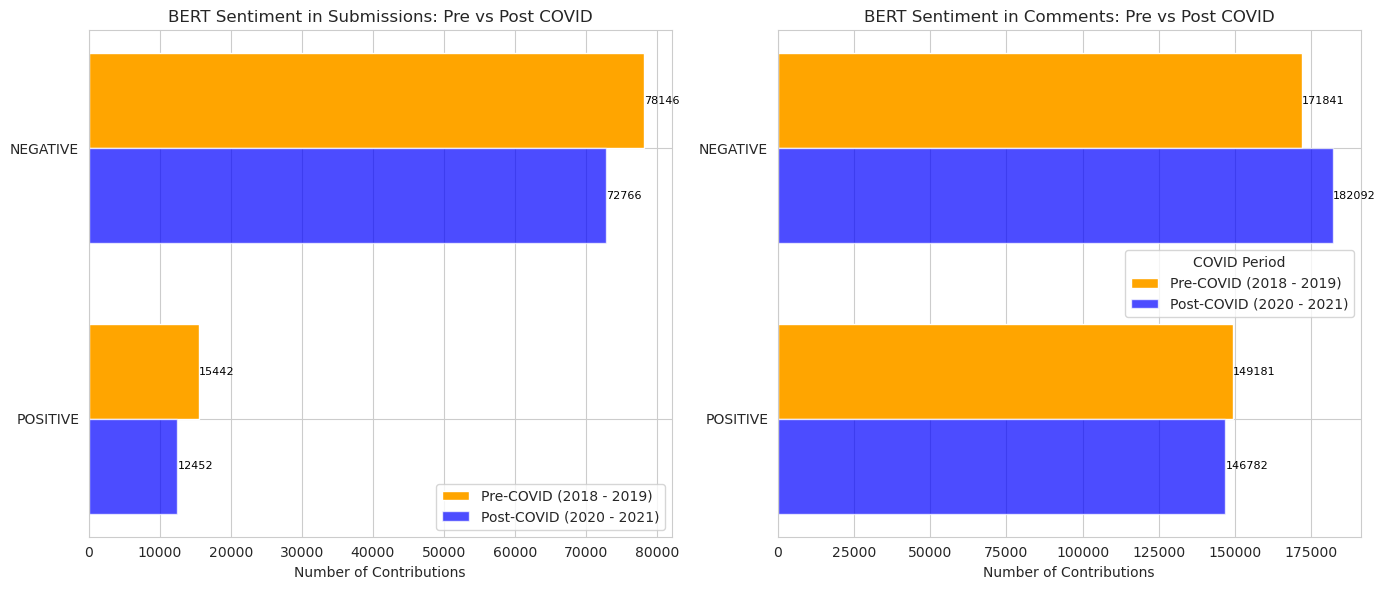

In [183]:
pre_covid_color = 'orange'
post_covid_color = 'blue'
bar_width = 0.35 

index = [0, 1]  

plt.figure(figsize=(14, 6))

# Submissions
plt.subplot(1, 2, 1)
pre_bert_counts = sub_pre_df['BERT_label'].value_counts().reindex(['POSITIVE', 'NEGATIVE'], fill_value=0)
post_bert_counts = sub_post_df['BERT_label'].value_counts().reindex(['POSITIVE', 'NEGATIVE'], fill_value=0)

plt.barh([i + bar_width / 2 for i in index], pre_bert_counts.values, bar_width, color=pre_covid_color, label='Pre-COVID (2018 - 2019)')
bars_post_bert = plt.barh([i - bar_width / 2 for i in index], post_bert_counts.values, bar_width, color=post_covid_color, alpha=0.7, label='Post-COVID (2020 - 2021)')

# adding values on bars
for i, value in enumerate(pre_bert_counts.values):
    plt.text(value + 50, index[i] + bar_width / 2, str(value), va='center', ha='left', fontsize=8, color='black')
for i, value in enumerate(post_bert_counts.values):
    plt.text(value + 50, index[i] - bar_width / 2, str(value), va='center', ha='left', fontsize=8, color='black')

plt.yticks(index, pre_bert_counts.index)
plt.title('BERT Sentiment in Submissions: Pre vs Post COVID')
plt.xlabel('Number of Contributions')
plt.legend()

# Comments
plt.subplot(1, 2, 2)
pre_bert_counts_com = coms_pre_df['BERT_label'].value_counts().reindex(['POSITIVE', 'NEGATIVE'], fill_value=0)
post_bert_counts_com = coms_post_df['BERT_label'].value_counts().reindex(['POSITIVE', 'NEGATIVE'], fill_value=0)

plt.barh([i + bar_width / 2 for i in index], pre_bert_counts_com.values, bar_width, color=pre_covid_color, label='Pre-COVID (2018 - 2019)')
bars_post_bert_com = plt.barh([i - bar_width / 2 for i in index], post_bert_counts_com.values, bar_width, color=post_covid_color, alpha=0.7, label='Post-COVID (2020 - 2021)')

# adding values on bars
for i, value in enumerate(pre_bert_counts_com.values):
    plt.text(value + 50, index[i] + bar_width / 2, str(value), va='center', ha='left', fontsize=8, color='black')
for i, value in enumerate(post_bert_counts_com.values):
    plt.text(value + 50, index[i] - bar_width / 2, str(value), va='center', ha='left', fontsize=8, color='black')

plt.yticks(index, pre_bert_counts_com.index)
plt.title('BERT Sentiment in Comments: Pre vs Post COVID')
plt.xlabel('Number of Contributions')
plt.legend(title="COVID Period")


plt.tight_layout()
plt.savefig('../../work/FCSS/BERT_sentiment_comparison.png', format='png', dpi=300)  # Save as PNG with high resolution
plt.show()

# SAVE FILES (withouth Index and remove Unnamed Columns)

In [146]:
# Submissions
sub_pre_df.loc[:, ~sub_pre_df.columns.str.contains('^Unnamed')].to_csv("../../work/FCSS/submission_pre_covid_sentiment.csv", index=False)
sub_post_df.loc[:, ~sub_post_df.columns.str.contains('^Unnamed')].to_csv("../../work/FCSS/submission_post_covid_sentiment.csv", index=False)

# Comments
coms_pre_df.loc[:, ~coms_pre_df.columns.str.contains('^Unnamed')].to_csv("../../work/FCSS/comments_pre_covid_sentiment.csv", index=False)
coms_post_df.loc[:, ~coms_post_df.columns.str.contains('^Unnamed')].to_csv("../../work/FCSS/comments_post_covid_sentiment.csv", index=False)

In [148]:
coms_post_df

,Unnamed: 0,link_id,subreddit,author,created_utc,permalink,ColumnID,Text,Segment,WC,...,Apostro,OtherP,Emoji,VADER_compound,VADER_scaled,BERT_sentiment,BERT_label,BERT_score,VADER_Sentiment,LIWC_Sentiment
0,0,ei91xe,Anxiety,LemonDread,2020-01-01 00:03:01,/r/Anxiety/comments/ei91xe/continuous_panic_at...,body,"Oh, that sucks.\n\nOh! Low potassium can also ...",1,82,...,0.00,0.00,0.0,-0.1615,41.925,"(POSITIVE, 0.9555140733718872)",POSITIVE,0.955514,Neutral,Negative
1,1,eiarx1,Anxiety,xStillSane,2020-01-01 00:04:24,/r/Anxiety/comments/eiarx1/i_am_not_ready_for_...,body,I can relate so much :( Literally trying to st...,1,15,...,0.00,26.67,0.0,-0.7251,13.745,"(POSITIVE, 0.937250554561615)",POSITIVE,0.937251,Negative,Negative
2,2,eia5uv,Anxiety,Srtcollinsdarylt,2020-01-01 00:13:19,/r/Anxiety/comments/eia5uv/just_feeling_a_litt...,body,I’ll give you my best advice since i felt the ...,1,47,...,8.51,0.00,0.0,0.7906,89.530,"(POSITIVE, 0.9560922384262085)",POSITIVE,0.956092,Positive,Neutral
3,3,ei91xe,Anxiety,Klynnd2015,2020-01-01 00:15:03,/r/Anxiety/comments/ei91xe/continuous_panic_at...,body,"Thanks for the tip. I managed to eat a little,...",1,51,...,5.88,0.00,0.0,0.8444,92.220,"(NEGATIVE, 0.6905863285064697)",NEGATIVE,0.690586,Positive,Positive
4,4,eia1xj,Anxiety,geeltulpen,2020-01-01 00:15:41,/r/Anxiety/comments/eia1xj/help_wellbutrin_anx...,body,I did not make it a week myself 😁,1,8,...,0.00,0.00,12.5,0.4588,72.940,"(NEGATIVE, 0.9985287189483643)",NEGATIVE,0.998529,Neutral,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
392801,392801,lofl0x,Anxiety,Amendus,2021-02-21 02:01:11,/r/Anxiety/comments/lofl0x/if_i_had_to_choose_...,body,I used to have intense pain in my stomach when...,1,39,...,5.13,5.13,0.0,-0.7721,11.395,"(NEGATIVE, 0.998722493648529)",NEGATIVE,0.998722,Negative,Negative
392802,392802,lolrhn,Anxiety,mangomelliii,2021-02-21 02:01:18,/r/Anxiety/comments/lolrhn/rabies/go6lc48/,body,thanks. do you know when a rabid dog would sho...,1,57,...,5.26,0.00,0.0,0.4860,74.300,"(POSITIVE, 0.9654041528701782)",POSITIVE,0.965404,Neutral,Neutral
392803,392803,lom39e,Anxiety,rzzbrrybby,2021-02-21 02:02:10,/r/Anxiety/comments/lom39e/my_mind_doesnt_race...,body,i totally understand! emotional responses can ...,1,94,...,1.06,4.26,0.0,0.9776,98.880,"(POSITIVE, 0.992672860622406)",POSITIVE,0.992673,Positive,Positive
392804,392804,lom39e,Anxiety,Entredarte,2021-02-21 02:03:45,/r/Anxiety/comments/lom39e/my_mind_doesnt_race...,body,What do you do when you’re around a group of p...,1,11,...,9.09,0.00,0.0,0.0000,50.000,"(NEGATIVE, 0.850227952003479)",NEGATIVE,0.850228,Neutral,NaN


# Differences in Tone Score

In [184]:
# Descriptive statistics for comments
comments_pre_stats = coms_pre_df[['BERT_score', 'VADER_compound', 'VADER_scaled', 'Tone']].describe()
comments_post_stats = coms_post_df[['BERT_score', 'VADER_compound', 'VADER_scaled', 'Tone']].describe()

# Descriptive statistics for submissions
submissions_pre_stats = sub_pre_df[['BERT_score', 'VADER_compound', 'VADER_scaled', 'Tone']].describe()
submissions_post_stats = sub_post_df[['BERT_score', 'VADER_compound', 'VADER_scaled', 'Tone']].describe()

display(comments_pre_stats, comments_post_stats, submissions_pre_stats, submissions_post_stats)

,BERT_score,VADER_compound,VADER_scaled,Tone
count,321022.000000,321022.000000,321022.000000,321022.000000
mean,0.961992,0.227205,61.361393,44.252024
std,0.088625,0.649452,32.475861,41.033536
min,0.500018,-0.999900,0.000000,1.000000
25%,0.979514,-0.381800,30.908091,1.510000
50%,0.995871,0.440400,72.022202,24.610000
75%,0.999122,0.811900,90.599060,94.700000
max,0.999893,0.999900,100.000000,99.000000


,BERT_score,VADER_compound,VADER_scaled,Tone
count,328874.000000,328874.000000,328874.000000,328874.000000
mean,0.962546,0.225839,61.291928,43.997637
std,0.087576,0.645772,32.288607,40.970430
min,0.500012,-0.999900,0.005000,1.000000
25%,0.979834,-0.381800,30.910000,1.400000
50%,0.995906,0.440400,72.020000,20.230000
75%,0.999063,0.802000,90.100000,94.700000
max,0.999892,1.000000,100.000000,99.000000


,BERT_score,VADER_compound,VADER_scaled,Tone
count,93588.000000,93588.000000,93588.000000,93588.000000
mean,0.968321,-0.255919,37.202764,15.025346
std,0.080096,0.747245,37.365967,24.333427
min,0.500010,-0.999900,0.000000,1.000000
25%,0.985004,-0.931600,3.415342,1.000000
50%,0.996171,-0.613600,19.316932,2.960000
75%,0.998702,0.548625,77.433993,20.230000
max,0.999890,0.999900,100.000000,99.000000


,BERT_score,VADER_compound,VADER_scaled,Tone
count,85218.000000,85218.000000,85218.000000,85218.000000
mean,0.969290,-0.266912,36.654384,13.946451
std,0.078861,0.747237,37.361826,23.488955
min,0.500013,-1.000000,0.000000,1.000000
25%,0.985882,-0.933100,3.345000,1.000000
50%,0.996307,-0.640800,17.960000,2.350000
75%,0.998683,0.542300,77.115000,16.190000
max,0.999889,1.000000,100.000000,99.000000


/tmp/ipykernel_29489/2877228304.py:1: FutureWarning: 

`shade` is now deprecated in favor of `fill`; setting `fill=True`.
This will become an error in seaborn v0.14.0; please update your code.

  sns.kdeplot(coms_pre_df['BERT_score'], label='Pre-COVID Comments', shade=True)
/tmp/ipykernel_29489/2877228304.py:2: FutureWarning: 

`shade` is now deprecated in favor of `fill`; setting `fill=True`.
This will become an error in seaborn v0.14.0; please update your code.

  sns.kdeplot(coms_post_df['BERT_score'], label='Post-COVID Comments', shade=True)


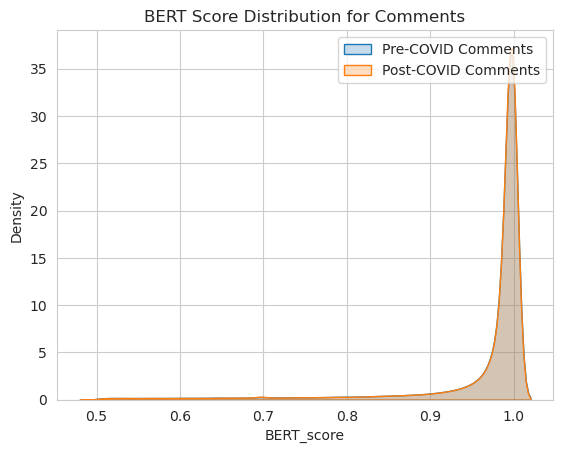

In [125]:
sns.kdeplot(coms_pre_df['BERT_score'], label='Pre-COVID Comments', shade=True)
sns.kdeplot(coms_post_df['BERT_score'], label='Post-COVID Comments', shade=True)
plt.title('BERT Score Distribution for Comments')
plt.legend()
plt.show()

In [288]:
print(sub_pre_df['VADER_compound'].var(), sub_post_df['VADER_compound'].var())
print(coms_pre_df['VADER_compound'].var(), coms_post_df['VADER_compound'].var())

print(sub_pre_df['Tone'].var(), sub_post_df['Tone'].var())
print(coms_pre_df['Tone'].var(), coms_post_df['Tone'].var())

print(sub_pre_df[['VADER_compound', 'Tone']].isnull().sum())
print(sub_post_df[['VADER_compound', 'Tone']].isnull().sum())

print(coms_pre_df[['VADER_compound', 'Tone']].isnull().sum())
print(coms_post_df[['VADER_compound', 'Tone']].isnull().sum())

0.5583745123408419 0.5583624317235505
0.4217882562404532 0.41702164657754853
592.1156640169893 551.7309859568359
1683.7511056289193 1678.5761751535413
VADER_compound    0
Tone              0
dtype: int64
VADER_compound    0
Tone              0
dtype: int64
VADER_compound    0
Tone              0
dtype: int64
VADER_compound    0
Tone              0
dtype: int64


# Correlations

In [286]:
display(sub_pre_df[['BERT_score', 'VADER_compound', 'VADER_scaled', 'Tone']].corr())
display(sub_post_df[['BERT_score', 'VADER_compound', 'VADER_scaled', 'Tone']].corr())
display(coms_post_df[['BERT_score', 'VADER_compound', 'VADER_scaled', 'Tone']].corr())
display(coms_pre_df[['BERT_score', 'VADER_compound', 'VADER_scaled', 'Tone']].corr())

,BERT_score,VADER_compound,VADER_scaled,Tone
BERT_score,1.000000,-0.100115,-0.100115,-0.054460
VADER_compound,-0.100115,1.000000,1.000000,0.545325
VADER_scaled,-0.100115,1.000000,1.000000,0.545325
Tone,-0.054460,0.545325,0.545325,1.000000


,BERT_score,VADER_compound,VADER_scaled,Tone
BERT_score,1.000000,-0.108334,-0.108334,-0.068210
VADER_compound,-0.108334,1.000000,1.000000,0.538708
VADER_scaled,-0.108334,1.000000,1.000000,0.538708
Tone,-0.068210,0.538708,0.538708,1.000000


,BERT_score,VADER_compound,VADER_scaled,Tone
BERT_score,1.000000,-0.024379,-0.024379,0.049595
VADER_compound,-0.024379,1.000000,1.000000,0.597354
VADER_scaled,-0.024379,1.000000,1.000000,0.597354
Tone,0.049595,0.597354,0.597354,1.000000


,BERT_score,VADER_compound,VADER_scaled,Tone
BERT_score,1.000000,-0.015366,-0.015366,0.061612
VADER_compound,-0.015366,1.000000,1.000000,0.612006
VADER_scaled,-0.015366,1.000000,1.000000,0.612006
Tone,0.061612,0.612006,0.612006,1.000000


# Mann-Whitney U Test (non-parametric) or t-test (parametric) for pre vs. post.

In [289]:
def test_sentiment(df_pre, df_post, columns, test_type='mannwhitney'):
    for column in columns:
        if test_type == 'mannwhitney':
            u_stat, p_value = mannwhitneyu(df_pre[column].dropna(), df_post[column].dropna(), alternative='two-sided')
            print(f"Mann-Whitney U Test for {column}: u-stat={u_stat}, p-value={p_value}")
        elif test_type == 'ttest':
            t_stat, p_value = ttest_ind(df_pre[column].dropna(), df_post[column].dropna(), equal_var=False)
            print(f"T-test for {column}: t-stat={t_stat}, p-value={p_value}")

sentiment_columns = ['BERT_score', 'VADER_compound', 'VADER_scaled', 'Tone']

test_sentiment(sub_pre_df, sub_post_df, sentiment_columns, 'mannwhitney')
test_sentiment(coms_pre_df, coms_post_df, sentiment_columns, 'mannwhitney')

test_sentiment(sub_pre_df, sub_post_df, sentiment_columns, 'ttest')
test_sentiment(coms_pre_df, coms_post_df, sentiment_columns, 'ttest')

Mann-Whitney U Test for BERT_score: u-stat=3969836339.5, p-value=0.10145117055243007
Mann-Whitney U Test for VADER_compound: u-stat=4020277297.5, p-value=0.0027969939975342646
Mann-Whitney U Test for VADER_scaled: u-stat=4019538960.0, p-value=0.0034837203264725877
Mann-Whitney U Test for Tone: u-stat=4122789752.0, p-value=1.6873825713814459e-37
Mann-Whitney U Test for BERT_score: u-stat=53063857873.0, p-value=0.0002627159851200994
Mann-Whitney U Test for VADER_compound: u-stat=53007685281.5, p-value=0.0036528930713773736
Mann-Whitney U Test for VADER_scaled: u-stat=53024447871.5, p-value=0.001757900077741547
Mann-Whitney U Test for Tone: u-stat=52940283939.5, p-value=0.04148068990806008
T-test for BERT_score: t-stat=-2.57648785306765, p-value=0.00998177050448267
T-test for VADER_compound: t-stat=3.107051802928367, p-value=0.001889931282435111
T-test for VADER_scaled: t-stat=3.099670186757909, p-value=0.0019376657400813845
T-test for Tone: t-stat=9.535735803182261, p-value=1.50600444128

# Effect Size Cohen's D

In [290]:
def cohen_d(x, y):
    mean_x = np.mean(x)
    mean_y = np.mean(y)
    std_x = np.std(x, ddof=1)
    std_y = np.std(y, ddof=1)
    pooled_std = np.sqrt((std_x ** 2 + std_y ** 2) / 2)
    return (mean_x - mean_y) / pooled_std

# BERT_score
bert_score_d_sub = cohen_d(sub_pre_df['BERT_score'].dropna(), sub_post_df['BERT_score'].dropna())
bert_score_d_com = cohen_d(coms_pre_df['BERT_score'].dropna(), coms_post_df['BERT_score'].dropna())
print("Cohen's d for BERT_score (Submissions):", bert_score_d_sub)
print("Cohen's d for BERT_score (Comments):", bert_score_d_com)

# VADER_compound
vader_compound_d_sub = cohen_d(sub_pre_df['VADER_compound'].dropna(), sub_post_df['VADER_compound'].dropna())
vader_compound_d_com = cohen_d(coms_pre_df['VADER_compound'].dropna(), coms_post_df['VADER_compound'].dropna())
print("Cohen's d for VADER_compound (Submissions):",  vader_compound_d_sub)
print("Cohen's d for VADER_compound (Comments):", vader_compound_d_com)

# VADER_scaled
vader_scaled_d_sub = cohen_d(sub_pre_df['VADER_scaled'].dropna(), sub_post_df['VADER_scaled'].dropna())
vader_scaled_d_com = cohen_d(coms_pre_df['VADER_scaled'].dropna(), coms_post_df['VADER_scaled'].dropna())
print("Cohen's d for VADER_scaled (Submissions):", vader_scaled_d_sub)
print("Cohen's d for VADER_scaled (Comments):", vader_scaled_d_com)

# Tone
tone_d_sub = cohen_d(sub_pre_df['Tone'].dropna(), sub_post_df['Tone'].dropna())
tone_d_com = cohen_d(coms_pre_df['Tone'].dropna(), coms_post_df['Tone'].dropna())
print("Cohen's d for Tone (Submissions):", tone_d_sub)
print("Cohen's d for Tone (Comments):", tone_d_com)

Cohen's d for BERT_score (Submissions): -0.01219510064156069
Cohen's d for BERT_score (Comments): -0.00628406719719726
Cohen's d for VADER_compound (Submissions): 0.014711727642521202
Cohen's d for VADER_compound (Comments): 0.0021101686631526924
Cohen's d for VADER_scaled (Submissions): 0.014676741723214943
Cohen's d for VADER_scaled (Comments): 0.0021451476676415367
Cohen's d for Tone (Submissions): 0.04511389531197096
Cohen's d for Tone (Comments): 0.0062042450216858525


In [291]:
most_negative_tone = sub_post_df.sort_values(by='Tone', ascending=True).head(100)
most_negative_vader = sub_post_df.sort_values(by='VADER_scaled', ascending=True).head(100)

In [271]:
most_negative_tone[['Text', 'Tone']].sample().values

array([['How can I calm down?\nTomorrow I’m rapping for my band at my youth group at my church. I’m so freaking nervous and I’m nervous I’ll mess up. How can I calm down???',
        1.0]], dtype=object)

In [276]:
most_negative_vader[['Text', 'VADER_scaled']].sample().values

array([['Tired of "I\'m just tired".\nI dont even know where to begin. For starters I suppose, I hate talking about.my issues, but I\'ve also never been accused of being under thorough. So here goes... \n\nA quick(ish) bio and back story: \n\nI\'m 28 years old, divorced, college drop out who graduated trade school with flying colors. I have a mortgage, truck payment, along with way more vehicles than any one person ought to have. Im in decent(ish) amounts of debt, but im managing?... \n\nAnyway\n\nMy parents separated when I was 5. I cant tell you a memory prior to the day my dad and I left. There\'s just nothing, no trace memories, no happy little glimpses of a family. Hell, for all I know, I was grown in a damn test tube and released at the age of 5 with a blank slate. (I know thats not the case, ive seen plenty of old home videos/pictures.) My mother was in and out of my life a few times over the course of the next 12 or so years. My dad drove big rigs alot while I was growing up. S